## ARCHITECT'S TRIAL—MULTI-AGENT EVOLUTION

#### IMPORTING LIBRARIES

In [252]:
from langchain_openai  import ChatOpenAI
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START, END
from langchain_core.tools import tool
from typing import Annotated
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from IPython.display import display, Image
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.messages import AIMessage
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import ToolException
from functools import wraps
from langchain.tools import StructuredTool
import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
import os

#### DEFINING A STATE

In [158]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    error: str

#### INITIALISING API KEYS

In [253]:
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["OPENWEATHERMAP_API_KEY"] = os.getenv("OPENWEATHERMAP_API_KEY")
llm = init_chat_model(os.getenv("MODEL"))

#### DEFINING TOOLS FOR THE USE OF DIFFERENT AGENTS

In [160]:
@tool
def multiply(a:int,b:int)->int:
    """Multiply two numbers"""
    return a*b

@tool
def add(a:int,b:int)->int:
    """Add two numbers"""
    return a+b

@tool
def subtract(a:int,b:int)->int:
    """Subtract two numbers"""
    return a-b

@tool
def divide(a:int,b:int)->int:
    """Divide two numbers"""
    return a/b

@tool
def weather(location:str)->str:
    """Get weather for a specified location"""
    weather = OpenWeatherMapAPIWrapper()
    if not location or not location.strip():
        return "No location provided"
    return weather.run(location)

@tool
def research(query:str)->str:
    """Search on something"""
    search=DuckDuckGoSearchRun()
    return search(query)

@tool
def python_code_executer(query:str)->str:
    """Execute a python code in python shell"""
    python_repl = PythonREPL()
    return python_repl.run(query)

#### DEFINING AN ERROR HANDLING FUNCTIONALITY THAT RASIES AN ERROR IS THE state IS EMPTY OR THERE HAS BEEN AN ERROR IN EXECUTION

In [226]:
def error_handler(agent):
    class SafeAgent:
        def invoke(self,state,config=None):
            if not state:
                raise ValueError(f"Empty input sent to model by {agent.name}")
            try:
                return agent.invoke(state,config)
            except Exception as e:
                print(f"Error: {e}")
                return state

        @property
        def name(self):
            return getattr(agent, "name", "agent")

    return SafeAgent()

#### CREATING A MATH AGENT

In [205]:
math_agent=create_react_agent(
    model=llm,
    tools=[divide,multiply,add,subtract],
    name="math_expert",
    prompt="You are a math agent.\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks. Do not take other tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text." 
        "-If you encounter an error then return it"
)
math_agent=error_handler(math_agent)

#### CREATING A WEATHER AGENT

In [227]:
weather_agent=create_react_agent(
    model=llm,
    tools=[weather],
    name="weather_expert",
    prompt="You are a weather agent."
        "INSTRUCTIONS:\n"
        "- Assist ONLY with weather-related tasks, DO NOT do any math\n"
        "- Only after you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
        "-If you encounter an error then return it"
)
weather_agent=error_handler(weather_agent)

#### CREATING A RESEARCH AGENT

In [207]:
research_agent=create_react_agent(
    model=llm,
    tools=[research],
    name="research_expert",
    prompt="You are a research agent.\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- Only after you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
        "-If you encounter an error then return it"
)
research_agent=error_handler(research_agent)

#### CREATING A PYTHON AGENT

In [208]:
python_agent=create_react_agent(
    model=llm,
    tools=[python_code_executer],
    name="python expert",
    prompt="You are a python code executer and a data visualisation agent\n"
        "INSTRUCTION\n"
        "- you have access to amtplotlib and pandas"
        "-Assist ONLY with python-related tasks. create graphs when asked\n"
        "Generate python code for data visualisation"
        "- Only after you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
        "-If you encounter an error then return it"
)
python_agent=error_handler(python_agent)

#### CREATING A SUPERVISOR TO MANAGE ALL THE AGENTS USING SUPERVISOR MUTLI AGENT MODEL

In [248]:
supervisor=create_supervisor(
    agents=[math_agent,research_agent,python_agent,weather_agent],
    model=llm,
    prompt=(
        "You are a supervisor managing 4 agents:\n"
        "- a research agent . Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "- a python agent. Assign python code tasks to this agent\n"
        "- a weather agent. Assign weather related tasks to this agent"
        "Assign work to one agent at a time, do not call agents in parallel\n"
        "Once you recieved an input from one agent then call the other agent"
        "Do not do any work yourself."
        # "Always display whatever you get from the agent "
        "Do not ask for user validation and show the result what meets the best to the input"
        "-If you encounter an error then display it"
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

#### DEFINING AN ERROR HANDLER FUNCTION FOR SUPERVISOR

In [249]:
def safe_supervisor(state: State):
    try:
        print("Succesful execution")
        return supervisor.invoke(state)
    except Exception as e:
        print(f"Error: {e}")
        state['error'] = AIMessage(content=f"System Error: {str(e)}")
        return state

#### VISUALISING THE WORKFLOW

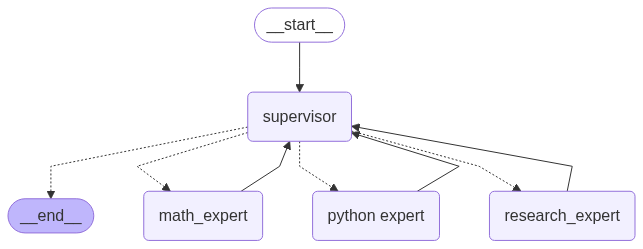

In [184]:
display(Image(supervisor.get_graph().draw_mermaid_png()))

#### GIVING CUSTOM INPUT

Succesful execution


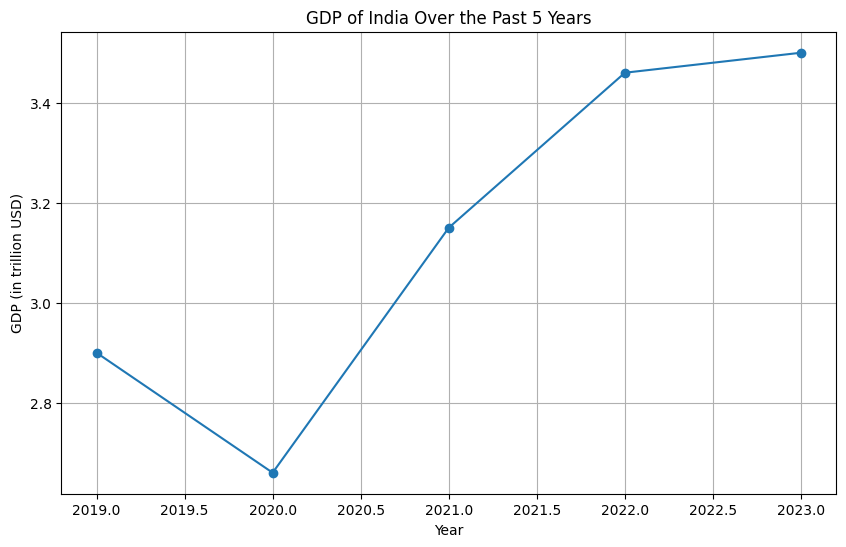

In [211]:
response=safe_supervisor({"messages": [HumanMessage(content=" Fetch the gdp data of india over past 5 years,generate a python code to plot a line chart for it and execute it")]})
# for msg in result["messages"]:
#     print(f"{msg.type}: {msg.content}")


#### OUTPUT

In [212]:
for m in response["messages"]:
    m.pretty_print()
    # print(m)
# print(response)

================================ Human Message =================================

 Fetch the gdp data of india over past 5 years,generate a python code to plot a line chart for it and execute it
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_research_expert (46ac6f85-c3fc-4ab5-b3bb-60923c044abb)
 Call ID: 46ac6f85-c3fc-4ab5-b3bb-60923c044abb
  Args:
================================= Tool Message =================================
Name: transfer_to_research_expert

Successfully transferred to research_expert
================================== Ai Message ==================================
Name: research_expert
Tool Calls:
  research (032291e6-c6a1-418e-a6ba-d50369db0d34)
 Call ID: 032291e6-c6a1-418e-a6ba-d50369db0d34
  Args:
    query: GDP data of India over the past 5 years
================================= Tool Message =================================
Name: research

The statistic shows GDP in India from 1987 

In [215]:
# config = {"configurable": {"thread_id": "2"}}
response=safe_supervisor({"messages":[HumanMessage(content="can you tell who is the pm of india.Find his age and multiply it by two")]})

Succesful execution


In [216]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

can you tell who is the pm of india.Find his age and multiply it by two
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_research_expert (bde42ea4-115f-489b-aa89-2b1018482ebf)
 Call ID: bde42ea4-115f-489b-aa89-2b1018482ebf
  Args:
================================= Tool Message =================================
Name: transfer_to_research_expert

Successfully transferred to research_expert
================================== Ai Message ==================================
Name: research_expert
Tool Calls:
  research (c14c0134-d1a5-4445-acf5-a47ca9431537)
 Call ID: c14c0134-d1a5-4445-acf5-a47ca9431537
  Args:
    query: who is the current prime minister of India and what is his age?
================================= Tool Message =================================
Name: research

List of all Prime Ministers of India till 2025: Narendra Mod

In [246]:
response=safe_supervisor({"messages":[HumanMessage(content="display weather of delhi")]})

Succesful execution


In [247]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

display weather of delhi
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_weather_expert (f9e9e43f-50de-421a-ad1d-b42a5d023915)
 Call ID: f9e9e43f-50de-421a-ad1d-b42a5d023915
  Args:
================================= Tool Message =================================
Name: transfer_to_weather_expert

Successfully transferred to weather_expert
================================== Ai Message ==================================
Name: weather_expert
Tool Calls:
  weather (0e631aba-facf-4a51-8581-d79868ad79ab)
 Call ID: 0e631aba-facf-4a51-8581-d79868ad79ab
  Args:
    location: delhi
================================= Tool Message =================================
Name: weather

In delhi, the current weather is as follows:
Detailed status: haze
Wind speed: 3.6 m/s, direction: 80°
Humidity: 58%
Temperature: 
  - Current: 31.05°C
  - High: 31.05°

In [250]:
response=safe_supervisor({"messages":[HumanMessage(content="can you gather the averagetemperature of delhi in last 5 years and generate a histogram for the same and execute it")]})

Succesful execution


In [251]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

can you gather the averagetemperature of delhi in last 5 years and generate a histogram for the same and execute it
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_weather_expert (ba2f961b-485a-4c77-a922-d8569afade4f)
 Call ID: ba2f961b-485a-4c77-a922-d8569afade4f
  Args:
================================= Tool Message =================================
Name: transfer_to_weather_expert

Successfully transferred to weather_expert
================================== Ai Message ==================================
Name: weather_expert

I cannot calculate the average temperature in Delhi over the last 5 years or create a histogram. I can only retrieve the current weather for a specific location.
================================== Ai Message ==================================
Name: weather_expert

Transferring back to supervisor
Tool Calls: